In [1]:
# %run ../Python/PageHD1.py
%matplotlib notebook
import scipy.sparse

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def pop_f(R, tuning, weights, f):
    return np.inner(R.T, weights@f(tuning))

def compute_HD(R, tuning, weights=None):
    if weights is None:
        weights = np.identity(tuning.size)
    HD_sin = pop_f(R, tuning, weights, np.sin)
    HD_cos = pop_f(R, tuning, weights, np.cos)
    HD = np.arctan(HD_sin / HD_cos)
    HD[HD_cos < 0] += np.pi
    HD[(HD_sin < 0) & (HD_cos > 0)] += 2*np.pi
    return HD

def read_map(prefix, with_distal=True):
    import csv
    proximal_objs = []
    distal_objs = None
    with open(prefix + '/Agent/map.info', newline='\n') as csvfile:
        mapreader = csv.reader(csvfile, delimiter=',')
        i = 0
        for row in mapreader:
            if i == 0:
                bound_x, bound_y = row
                bound_x, bound_y = float(bound_x), float(bound_y)
            elif with_distal and i == 1:
                distal_objs = np.array(row, dtype=float)
            else:
                proximal_objs.append(list(row))
            i += 1
    return (bound_x, bound_y), distal_objs, np.array(proximal_objs, dtype=float)


# Below are from https://gist.github.com/pv/8036995

def edge_project(pts, fd, h0=1.0):
    """
    project points back on the boundary (where fd=0) using numerical gradient

    note : you should specify h0 according to your actual mesh size
    """
    deps = sqrt(np.finfo(float).eps)*h0
    d = fd(pts)
    dgradx = (fd(pts + [deps, 0]) - d) / deps
    dgrady = (fd(pts + [0, deps]) - d) / deps
    dgrad2 = dgradx**2 + dgrady**2
    dgrad2[dgrad2 == 0] = 1.
    # calculate gradient vector (minus)
    pgrad = np.vstack([d*dgradx/dgrad2, d*dgrady/dgrad2]).T
    return pgrad

from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, rate_map, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    rates = []
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        rates.append(rate_map[tuple(vor.points[p1].tolist())])
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        try:
            ridges = all_ridges[p1]
        except KeyError:
            rates = rates[:-1]
            continue
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())
        
    return new_regions, np.asarray(new_vertices), rates

In [2233]:
#outdir = 'pandapics/HD_VIS_out/'
outdir = 'pandapics/PLACE_out' #_with_good_PLACE_cells_20170924'
rate_buf_ival = 2**-6
weights_buf_ival = 10.0
with_distal=False

bounds, distal_objects, proximal_objects = read_map(outdir, with_distal=with_distal)
bound_x = bounds[0]
bound_y = bounds[1]

num_objects = proximal_objects.shape[0]
if with_distal:
    num_objects += distal_objects.shape[0]
#print(proximal_objects)

N_VIS = num_objects * 60
N_VIS2 = 500
N_HD = 300
N_FV = 2 * 50
N_FVxHD = 2 * N_HD
N_GRID = 100
N_GRIDxFVxHD = 2 * 2 * 200
N_PLACE = 200

<IPython.core.display.Javascript object>


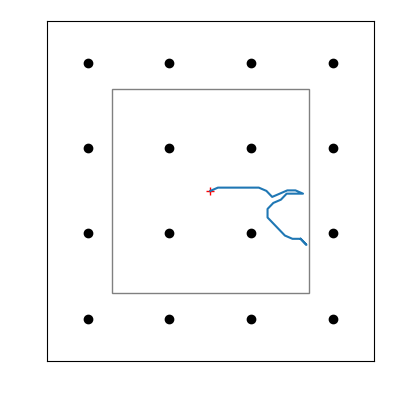

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


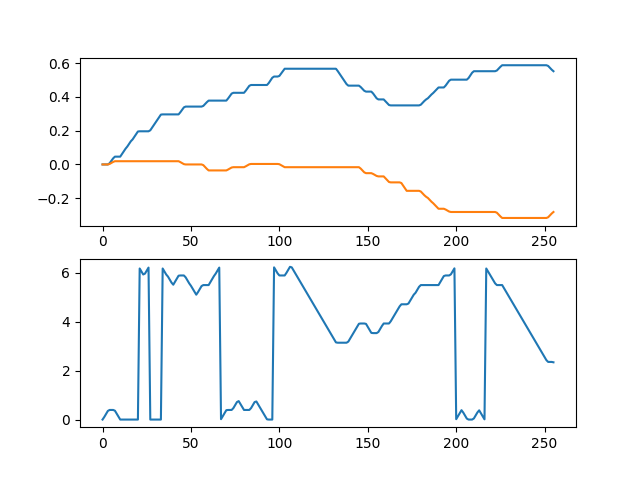

In [2256]:
test_start_t = 0 # 101 # 1017 # 355
test_stop_t = test_start_t + 4 # 16 # 1022
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)

agent_hist = read_rates(outdir, 'Agent', 3, fname='history.bin')
fig, ax = plt.subplots(figsize=(4,4))
plt.tight_layout()
ax.plot([0], [0], '+', color='red')
ax.set_xlim(-bound_x/0.6, bound_x/0.6)
ax.set_ylim(-bound_y/0.6, bound_y/0.6)
ax.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
ax.scatter(proximal_objects[::1, 0], proximal_objects[::1, 1], c='black')
ax.plot(agent_hist[0][test_start_i:test_stop_i], agent_hist[1][test_start_i:test_stop_i])
#ax.plot()

import matplotlib.patches as mplp
ax.add_patch(mplp.Rectangle((-0.6, -0.6), 1.2, 1.2, fill=False, edgecolor='gray'))
fig.savefig('env.png', dpi=300, edgecolor='none', transparent=True)

fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(agent_hist[0][test_start_i:test_stop_i])
ax[0].plot(agent_hist[1][test_start_i:test_stop_i])
ax[1].plot(agent_hist[2][test_start_i:test_stop_i])

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


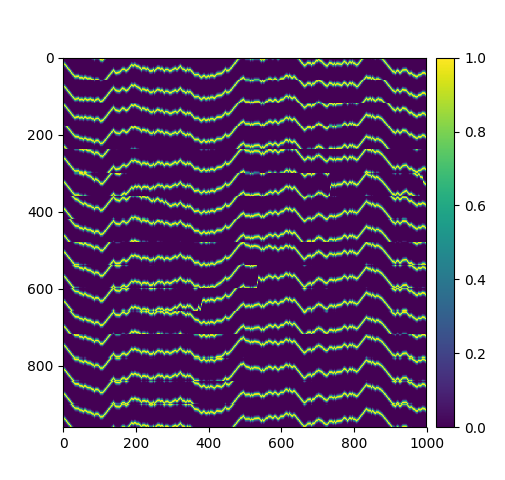

Sparsity: 0.139257


<IPython.core.display.Javascript object>


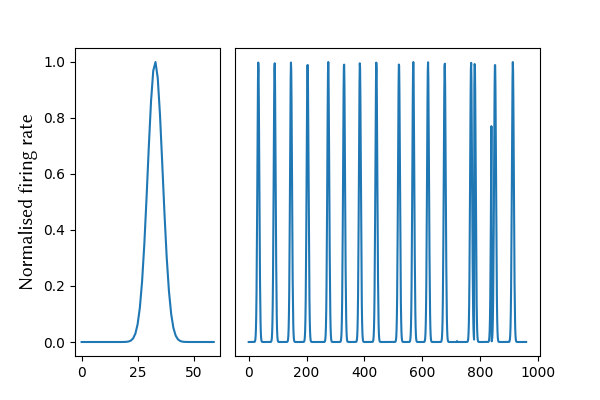

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [2306]:
R_VIS = read_rates(outdir, 'VIS', N_VIS)
imshow(R_VIS[:, -1000:]) #test_start_i:test_stop_i])
print('Sparsity: %f' % (np.mean(np.sum(R_VIS, 0)) / N_VIS))

import matplotlib as mpl
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/share/fonts/opentype/linux-libertine/LinBiolinum_R.otf')
#mpl.rc('font', family = 'serif', serif=prop)

fig = plt.figure(figsize=(6, 4))
ax0 = plt.subplot2grid((1,3), (0,0))
ax1 = plt.subplot2grid((1,3), (0,1), colspan=2)
#plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.05)
ax0.plot(np.arange(60), R_VIS[:60, 90])
ax1.plot(np.arange(R_VIS.shape[0]), R_VIS[:, 215])
#ax0.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
ax1.tick_params(left='off', labelleft='off') #fontproperties=prop)
ax0.set_ylabel(r'Normalised firing rate', fontproperties=prop, size=14)
fig.savefig('vis.png', dpi=300, edgecolor='none', transparent=True)

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


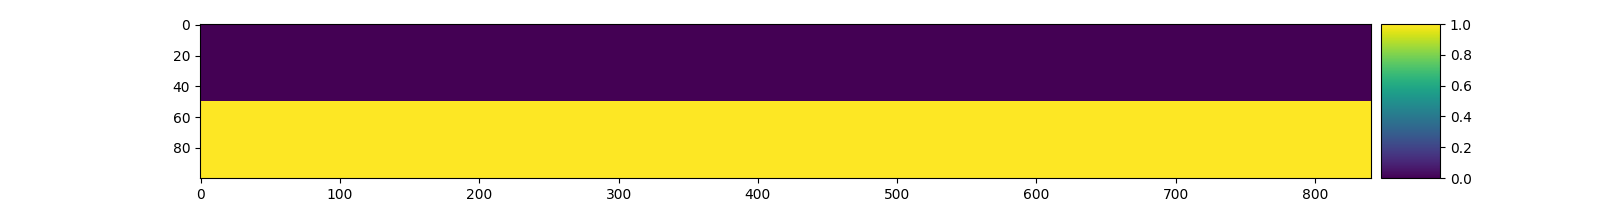

Sparsity: 0.500000


In [1688]:
R_FV = read_rates(outdir, 'FV', N_FV)
imshow(R_FV[:, -2000:])
print('Sparsity: %f' % (np.mean(np.sum(R_FV, 0)) / N_FV))

<IPython.core.display.Javascript object>


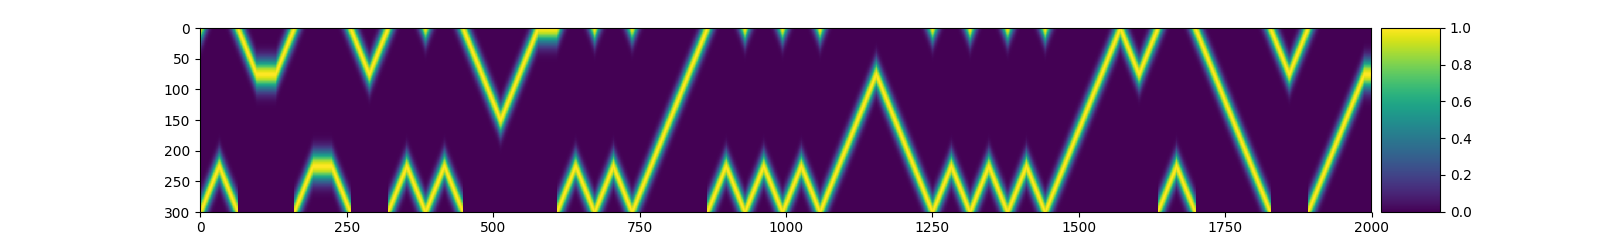

Sparsity: 0.133848


In [28]:
R_HD = read_rates(outdir, 'HD', N_HD)
imshow(R_HD[:, -2000:])
print('Sparsity: %f' % (np.mean(np.sum(R_HD, 0)) / N_HD))

(100, 18703) 6400 25600 0.015625
[[57 44 83]
 [65 47 36]
 [17  1 64]]


/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


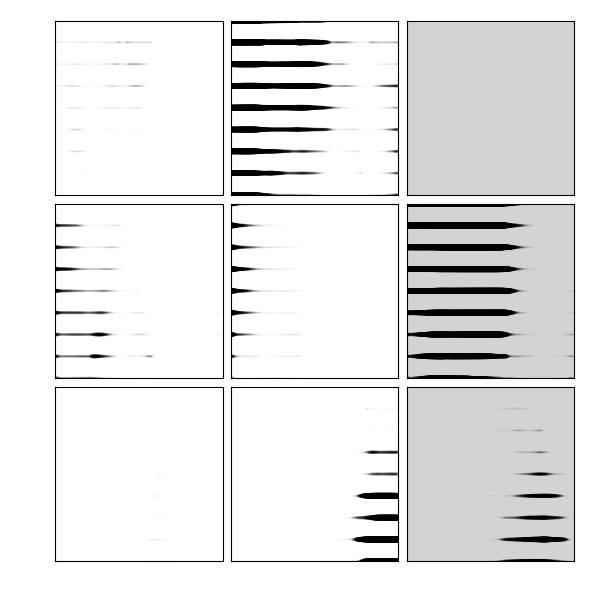

In [2223]:
bound_x_grid, bound_y_grid = 1, 0.25
test_start_t = 100 # 6600
test_stop_t = test_start_t + 300
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
start, stop = test_start_i, test_stop_i # -10000, -1
#start, stop = -10000, -1
step = 1
agent_hist = read_rates(outdir, 'Agent', 3, fname='history.bin')
X, Y = agent_hist[0][start:stop:step], agent_hist[1][start:stop:step]
#R = read_rates(outdir, 'PLACE', N_PLACE)[:, start:stop:step].copy()
R = read_rates(outdir, 'GRID', N_GRID)[:, start:stop:step].copy()
R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop:step].copy()
R_max_early = np.max(read_rates(outdir, 'PLACE', N_PLACE)[:, :stop-start:step])
print(R.shape, start, stop, rate_buf_ival)

# Proper place cells:
#J = np.array([[72, 32],[34, 44]])
Jshape = np.array([3, 3])
J = np.random.choice(np.arange(R.shape[0]), np.prod(Jshape), replace=False).reshape(Jshape)
# 77, 49, 80, 49, 72, 66, 73, 70
#J = np.array([[119, 113, 179],[145, 106, 139],[155, 166, 50]]) # 166, 7, 70, 22; 199
#J = np.array([[119, 145, 52],[113, 106, 51],[155, 166, 50]]) # 166, 7, 70, 22; 199
#R[50] = read_rates(outdir, 'PLACE', N_PLACE)[166, 0:stop-start:step].copy() / R_max_early
#R[51] = read_rates(outdir, 'PLACE', N_PLACE)[106, 0:stop-start:step].copy() / R_max_early
#R[52] = read_rates(outdir, 'PLACE', N_PLACE)[145, 0:stop-start:step].copy() / R_max_early

# Stupid no-proximal cells:
#Jshape = np.array([2,2])
#J = np.array([[143, 50], [34, 51]])
#R[50] = read_rates(outdir, 'PLACE', N_PLACE)[143, 0:stop-start:step].copy() / R_max_early
#R[51] = read_rates(outdir, 'PLACE', N_PLACE)[34, 0:stop-start:step].copy() / R_max_early

R_max = np.max(R)
print(J)
fig, ax = plt.subplots(*(J.shape), figsize=2*Jshape)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax_flat = ax.flatten()
for i, j in enumerate(J.flatten()):
    C = np.zeros((len(R[j]), 4))
    R_j = R[j]/R_max
    R_j[R_j<0] = 0 # occasionally there are tiny negative values ...
    C[:, 3] = R_j
    #R_j[R_FV[0,:len(R_j)]>0] = 0 # remove points without forward motion
    ax_flat[i].scatter(X, Y, 12*R_j, C, cmap=plt.get_cmap('binary'))
    ax_flat[i].set_xlim(-bound_x_grid, bound_x_grid)
    ax_flat[i].set_ylim(-bound_y_grid, bound_y_grid)
    ax_flat[i].tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
for a in ax[:, J.shape[1]-1]:
    a.set_facecolor('lightgray')
fig.patch.set_alpha(0.)
#fig.savefig('place.png', edgecolor='none', dpi=300) # facecolor=fig.get_facecolor()

2537 2537


/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


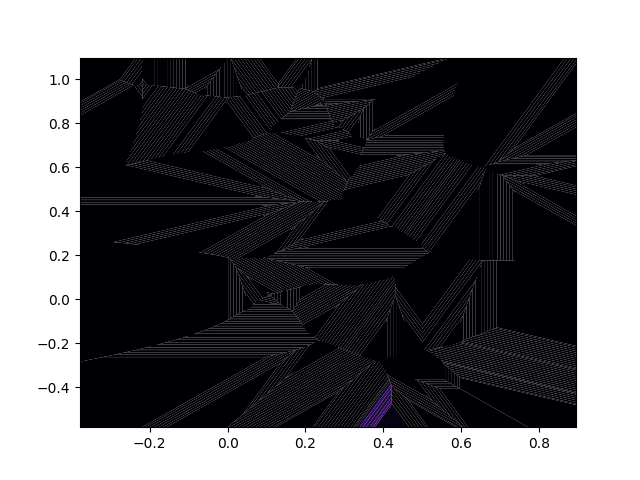

(-0.58270657658576963, 1.099538004398346)

In [568]:
test_start_t = 0 # 2000
test_stop_t = test_start_t + 50
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
start, stop = test_start_i, test_stop_i # -10000, -1
step = 1

j = 30

agent_hist = read_rates(outdir, 'Agent', 3, fname='history.bin')[:2, start:stop:step]
R = read_rates(outdir, 'PLACE', N_PLACE)[j, start:stop:step].copy()
R_FV = read_rates(outdir, 'FV', N_FV)[0, start:stop:step].copy()
R[R_FV>0] = 0

points = agent_hist.T
rates = {}
for i, p in enumerate(points):
    rates[tuple(p.tolist())] = float(R[i])

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices, rates = voronoi_finite_polygons_2d(vor, rates)

import matplotlib.cm as cm

# print cm.hot(0.3)
print(len(rates), len(regions))

fig, ax = plt.subplots()

for i, region in enumerate(regions):
    polygon = vertices[region]
    ax.fill(*zip(*polygon), c=cm.inferno(rates[i]), lw=0)

#ax.plot(points[:,0], points[:,1], 'ko')
#plt.axis('equal')
ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

<IPython.core.display.Javascript object>


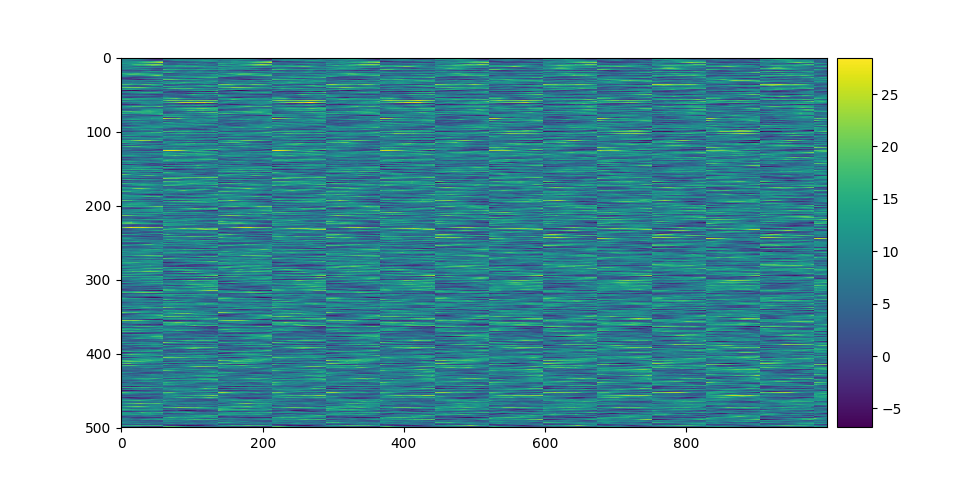

<IPython.core.display.Javascript object>


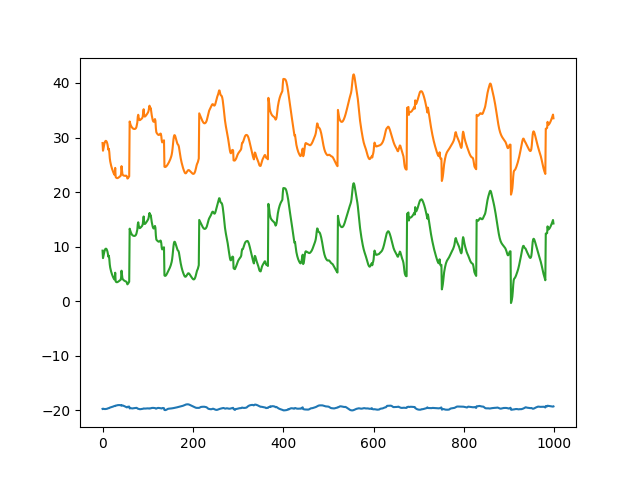

<IPython.core.display.Javascript object>


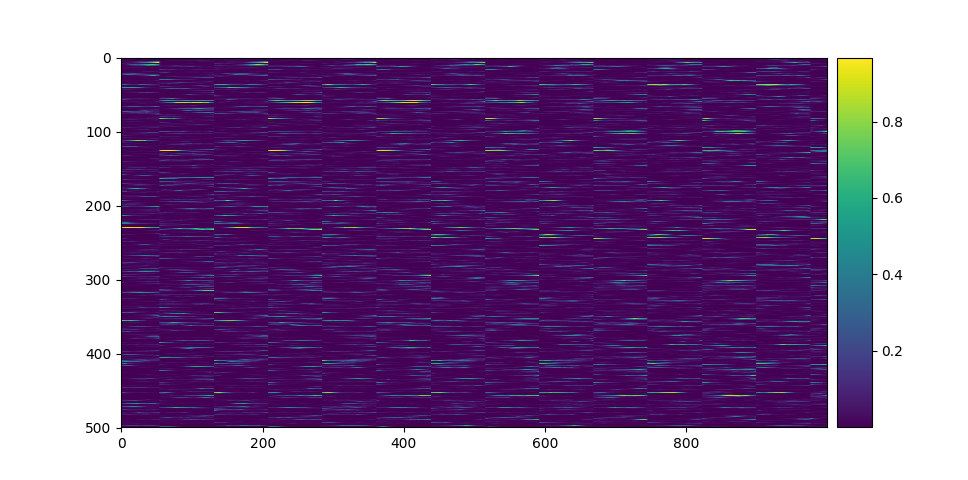

<IPython.core.display.Javascript object>


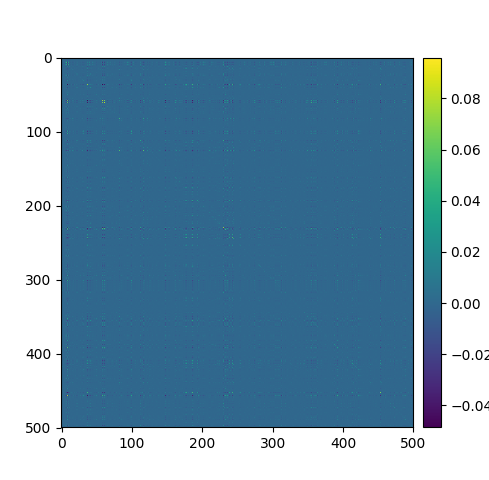

-19.5274 27.8238
Sparsity: 0.039051


In [1870]:
#start, stop = test_start_i, test_stop_i
start, stop = -1000, -1

H_VIS2_VIS2_INH = accumulate_activation(outdir, 'VIS2', ['VIS2'], N_VIS2, slice(start, stop), INH=True) # 'AHVxHD'
H_VIS_VIS2 = accumulate_activation(outdir, 'VIS2', ['VIS'], N_VIS2, slice(start, stop))
imshow((H_VIS2_VIS2_INH + H_VIS_VIS2)) #[W_VIS_GRID_idx])
fig, ax = plt.subplots()
# blue, orange, green, red, purple
j = 12
ax.plot(H_VIS2_VIS2_INH[j])
ax.plot(H_VIS_VIS2[j])
ax.plot(H_VIS2_VIS2_INH[j] + H_VIS_VIS2[j])

R_VIS2 = read_rates(outdir, 'VIS2', N_VIS2)[:, start:stop]
imshow(R_VIS2) # [W_VIS_HD_idx])
imshow(np.cov(R_VIS2)) # [W_VIS_HD_idx]))
#fig, ax = plt.subplots()
#ax = ax.flatten()
#ax.plot(R_VIS2[j])
#ax[0].plot(R_HD[W_VIS_HD_idx[-10]])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -1])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -21])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -41])

print(np.mean(H_VIS2_VIS2_INH), np.mean(H_VIS_VIS2))
print('Sparsity: %f' % (np.mean(R_VIS2)))
#print(np.mean(read_rates(outdir, 'HD', N_HD), 0))

<IPython.core.display.Javascript object>


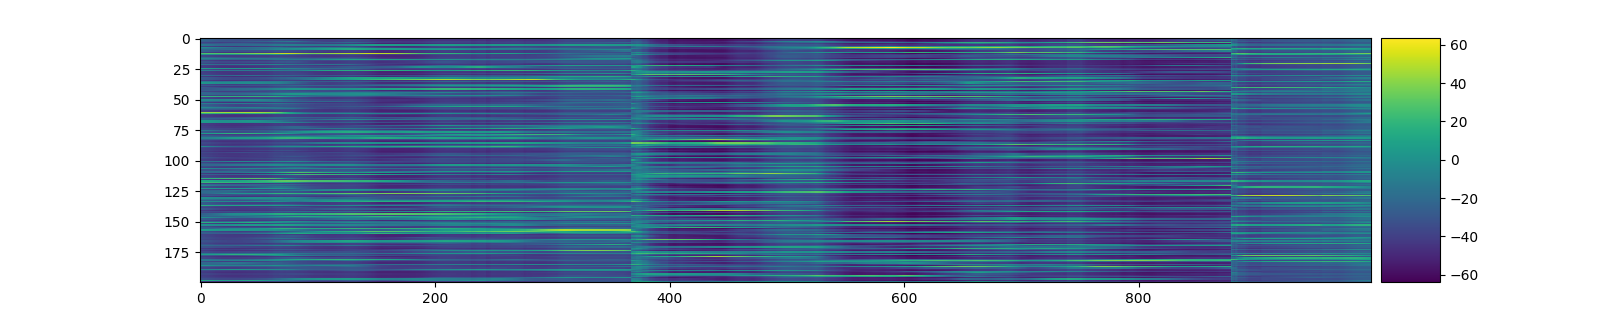

<IPython.core.display.Javascript object>


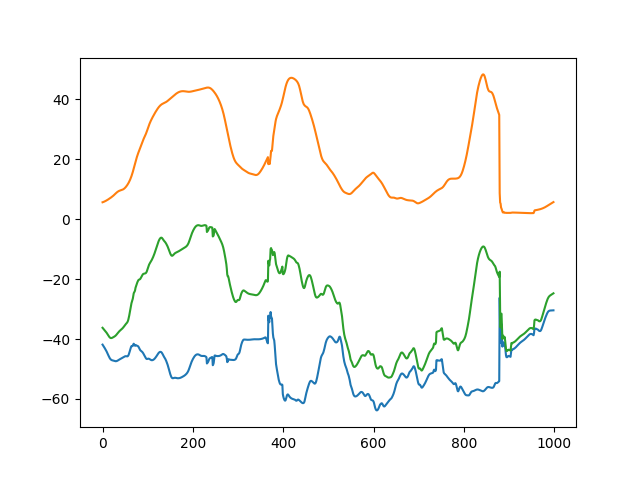

<IPython.core.display.Javascript object>


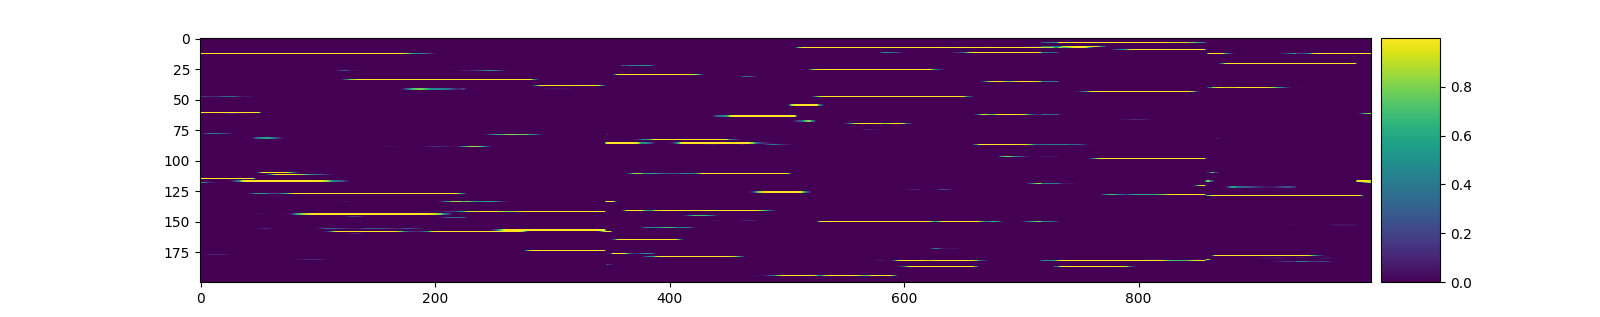

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


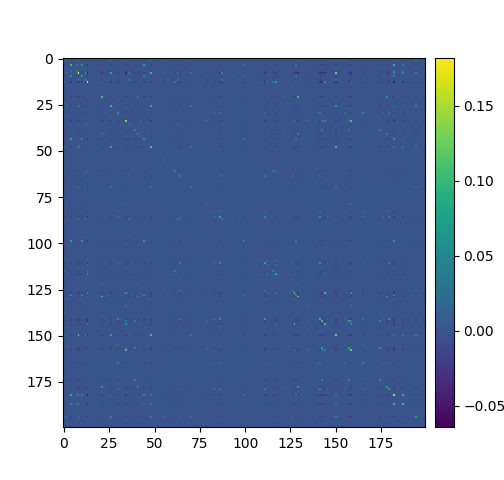

-48.9681 20.6211
Sparsity: 0.024346


In [2206]:
#start, stop = test_start_i, test_stop_i
start, stop = -1000, -1

H_PLACE_PLACE_INH = accumulate_activation(outdir, 'PLACE', ['PLACE'], N_PLACE, slice(start, stop), INH=True) # 'AHVxHD'
#H_PLACE_PLACE = accumulate_activation(outdir, 'PLACE', ['PLACE'], N_PLACE, slice(start, stop))
#H_VIS_PLACE = accumulate_activation(outdir, 'PLACE', ['VIS'], N_PLACE, slice(start, stop))
H_GRID_PLACE = accumulate_activation(outdir, 'PLACE', ['GRID'], N_PLACE, slice(start, stop))
imshow((H_PLACE_PLACE_INH + H_GRID_PLACE)) # + H_VIS_PLACE  # + H_PLACE_PLACE
fig, ax = plt.subplots()
# blue, orange, green, red, purple
j = 47
ax.plot(H_PLACE_PLACE_INH[j])
#ax.plot(H_PLACE_PLACE[j])
#ax.plot(H_VIS_PLACE[j])
ax.plot(H_GRID_PLACE[j])
ax.plot(H_PLACE_PLACE_INH[j] + H_GRID_PLACE[j]) # + H_VIS_PLACE[j] #  + H_PLACE_PLACE[j]

R_PLACE = read_rates(outdir, 'PLACE', N_PLACE)[:, start:stop]
imshow(R_PLACE) # [W_VIS_HD_idx])
imshow(np.cov(R_PLACE)) # [W_VIS_HD_idx]))
#fig, ax = plt.subplots(2)
#ax = ax.flatten()
#ax[0].plot(R_PLACE[j])
#ax[0].plot(R_HD[W_VIS_HD_idx[-10]])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -1])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -21])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -41])

print(np.mean(H_PLACE_PLACE_INH), np.mean(H_GRID_PLACE)) # np.mean(H_VIS_PLACE),  # np.mean(H_PLACE_PLACE), 
print('Sparsity: %f' % (np.mean(R_PLACE)))
#print(np.mean(read_rates(outdir, 'HD', N_HD), 0))

<IPython.core.display.Javascript object>


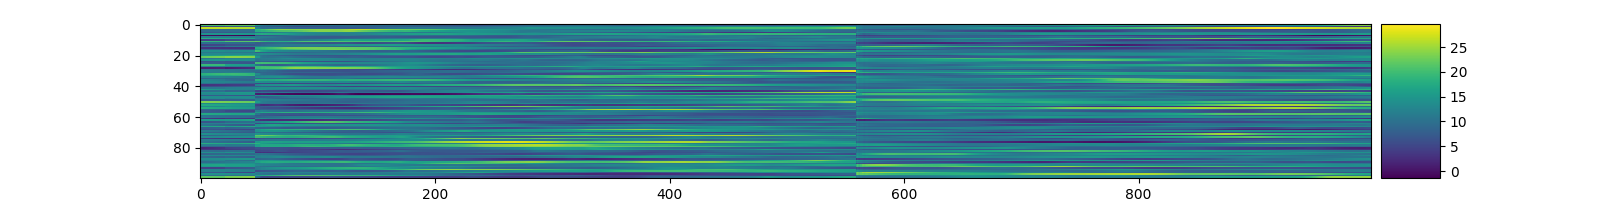

<IPython.core.display.Javascript object>


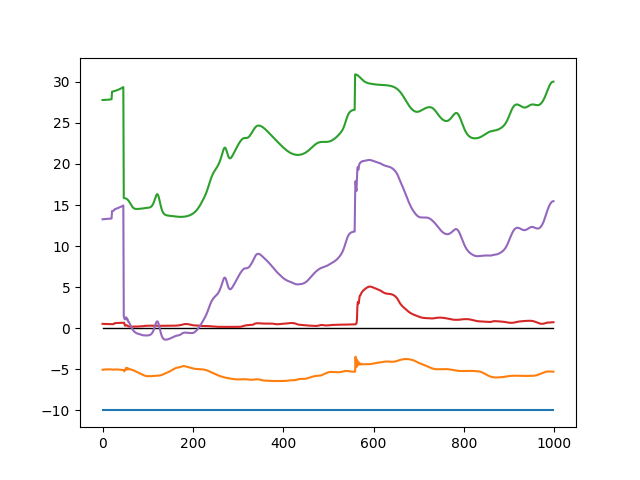

<IPython.core.display.Javascript object>


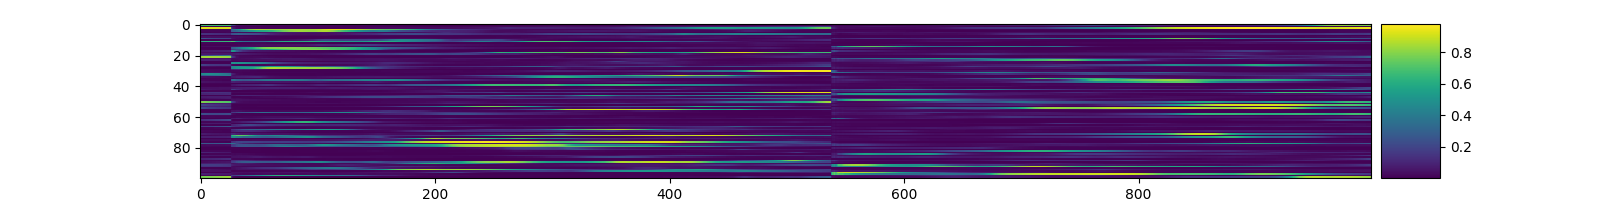

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


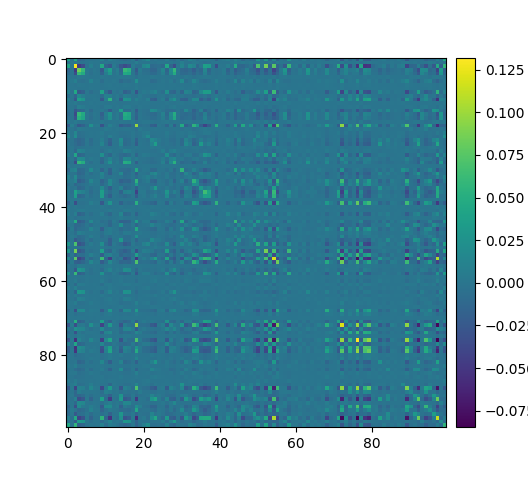

-5.33678 -10.0 25.535 1.36202
Sparsity: 0.106841


In [2207]:
#start, stop = test_start_i, test_stop_i
start, stop = -1000, -1

R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]
R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
H_VIS_GRID_INH = accumulate_activation(outdir, 'GRID', ['VIS'], N_GRID, slice(start, stop), INH=True)
H_GRID_GRID_INH = accumulate_activation(outdir, 'GRID', ['GRID'], N_GRID, slice(start, stop), INH=True) # 'AHVxHD'
H_VIS_GRID = accumulate_activation(outdir, 'GRID', ['VIS'], N_GRID, slice(start, stop))
H_GRIDxFVxHD_GRID = accumulate_activation(outdir, 'GRID', ['GRIDxFVxHD'], N_GRID, slice(start, stop))
#H_PLACE_GRID = accumulate_activation(outdir, 'GRID', ['PLACE'], N_GRID, slice(start, stop))
imshow((H_VIS_GRID_INH + H_GRID_GRID_INH + H_VIS_GRID + H_GRIDxFVxHD_GRID)) # H_PLACE_GRID + 
fig, ax = plt.subplots()
# blue, orange, green, red, purple, bro/wn
j = 45
ax.plot(R_FV[0]*np.min(H_VIS_GRID_INH), color='black', lw=1)
ax.plot(H_VIS_GRID_INH[j])
ax.plot(H_GRID_GRID_INH[j])
ax.plot(H_VIS_GRID[j])
#ax.plot(H_PLACE_GRID[j])
ax.plot(H_GRIDxFVxHD_GRID[j])
ax.plot(H_VIS_GRID_INH[j] + H_GRID_GRID_INH[j] + H_VIS_GRID[j] + H_GRIDxFVxHD_GRID[j]) # H_PLACE_GRID[j] + 

R_GRID = read_rates(outdir, 'GRID', N_GRID)[:, start:stop]
imshow(R_GRID) # [W_VIS_HD_idx])
imshow(np.cov(R_GRID)) # [W_VIS_HD_idx]))
#fig, ax = plt.subplots(2)
#ax = ax.flatten()
#ax[0].plot(R_GRID[40])
#ax[0].plot(R_HD[W_VIS_HD_idx[-10]])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -1])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -21])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -41])

print(np.mean(H_GRID_GRID_INH), np.mean(H_VIS_GRID_INH), np.mean(H_VIS_GRID), np.mean(H_GRIDxFVxHD_GRID)) # np.mean(H_PLACE_GRID), 
print('Sparsity: %f' % (np.mean(R_GRID)))
#print(np.mean(read_rates(outdir, 'HD', N_HD), 0))

<IPython.core.display.Javascript object>


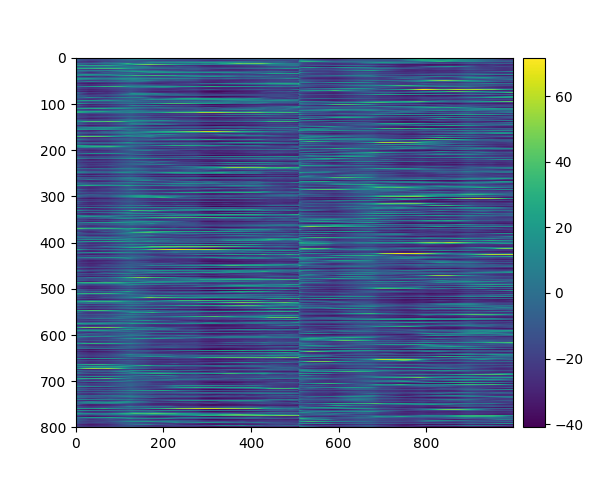

<IPython.core.display.Javascript object>


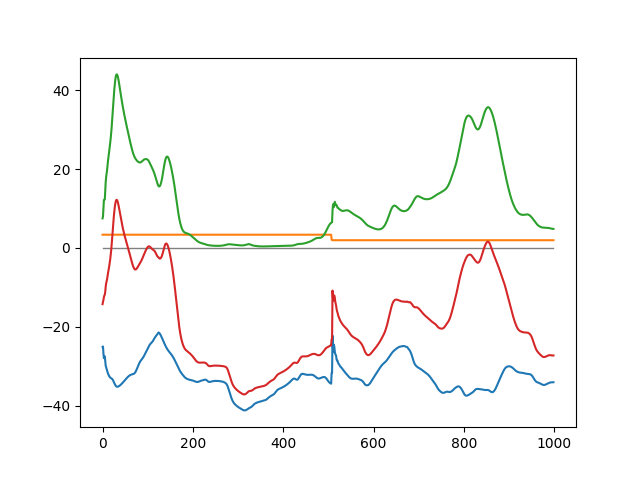

<IPython.core.display.Javascript object>


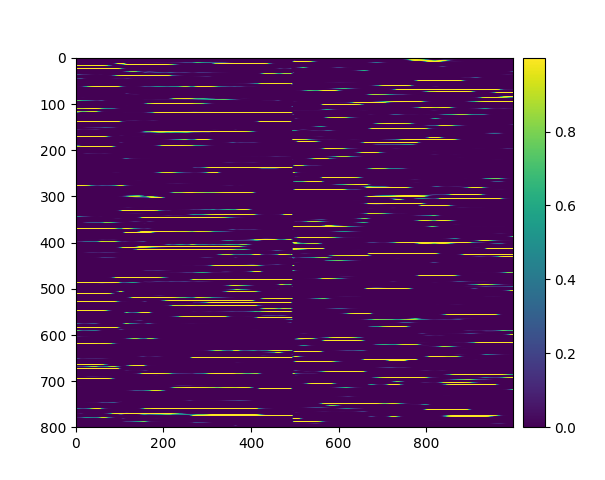

<IPython.core.display.Javascript object>


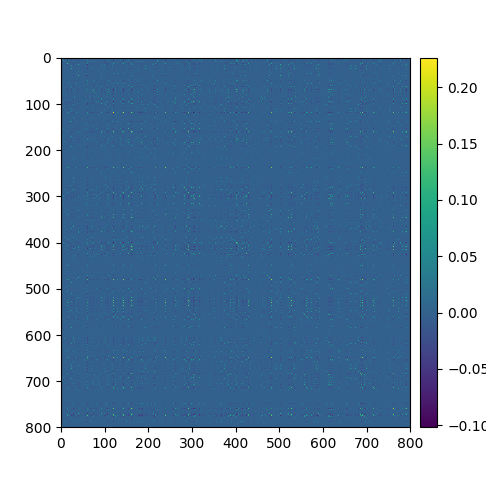

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


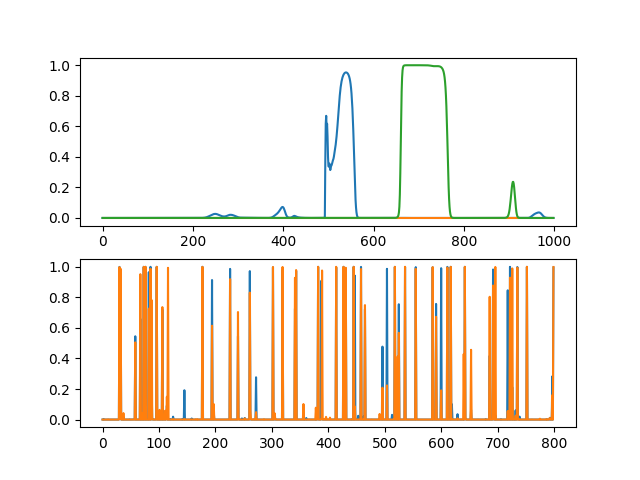

-32.7836 6.22658 16.1694
Sparsity: 0.054762


In [2208]:
start, stop = -1000, -1

R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
#R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]

H_GRIDxFVxHD_INH = accumulate_activation(outdir, 'GRIDxFVxHD', ['GRIDxFVxHD'], N_GRIDxFVxHD, slice(start, stop), INH=True) # 'HD'
H_GRID_GRIDxFVxHD = accumulate_activation(outdir, 'GRIDxFVxHD', ['GRID'], N_GRIDxFVxHD, slice(start, stop))
#H_FV_GRIDxFVxHD = accumulate_activation(outdir, 'GRIDxFVxHD', ['FV'], N_GRIDxFVxHD, slice(start, stop))
#H_HD_GRIDxFVxHD = accumulate_activation(outdir, 'GRIDxFVxHD', ['HD'], N_GRIDxFVxHD, slice(start, stop))
#H_FVxHD_GRIDxFVxHD = H_FV_GRIDxFVxHD + H_HD_GRIDxFVxHD
H_FVxHD_GRIDxFVxHD = accumulate_activation(outdir, 'GRIDxFVxHD', ['FVxHD'], N_GRIDxFVxHD, slice(start, stop))
H_GRIDxFVxHD = H_GRIDxFVxHD_INH + H_GRID_GRIDxFVxHD + H_FVxHD_GRIDxFVxHD
imshow(H_GRIDxFVxHD) #[W_idx_s])

# blue, orange, green, red, purple
fig, ax = plt.subplots()
j = 190
ax.plot(R_FV[0]*np.min(H_GRIDxFVxHD_INH[j]), color='gray', lw=1)
ax.plot(H_GRIDxFVxHD_INH[j])
#ax.plot(H_FV_GRIDxFVxHD[j])
#ax.plot(H_HD_GRIDxFVxHD[j])
ax.plot(H_FVxHD_GRIDxFVxHD[j])
ax.plot(H_GRID_GRIDxFVxHD[j])
ax.plot(H_GRIDxFVxHD[j])

R_GRIDxFVxHD = np.array(read_rates(outdir, 'GRIDxFVxHD', N_GRIDxFVxHD)[:, start:stop])
imshow(R_GRIDxFVxHD) # [W_idx_s])
imshow(np.cov(R_GRIDxFVxHD))
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_GRIDxFVxHD[10])
ax[0].plot(R_GRIDxFVxHD[250])
ax[0].plot(R_GRIDxFVxHD[500])
ax[1].plot(R_GRIDxFVxHD[:, -1])
ax[1].plot(R_GRIDxFVxHD[:, -17])

print(np.mean(H_GRIDxFVxHD_INH), np.mean(H_FVxHD_GRIDxFVxHD), np.mean(H_GRID_GRIDxFVxHD)) # np.mean(H_FV_GRIDxFVxHD), np.mean(H_HD_GRIDxFVxHD
print('Sparsity: %f' % (np.mean(np.sum(R_GRIDxFVxHD, 0)) / N_GRIDxFVxHD))

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


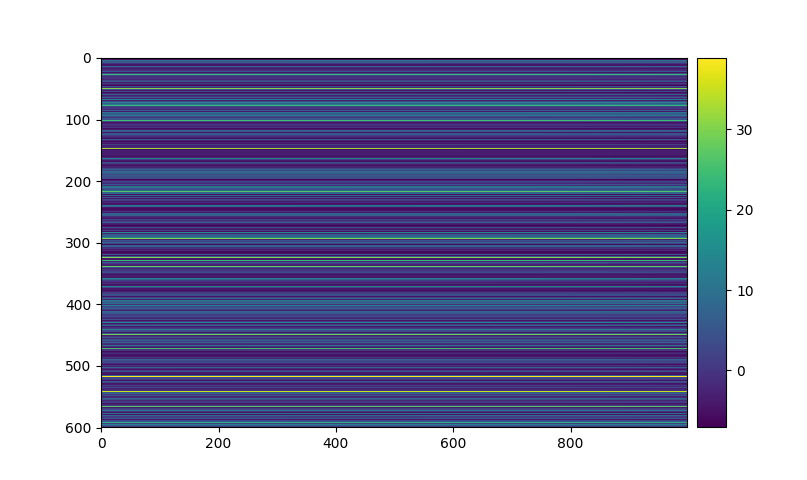

<IPython.core.display.Javascript object>


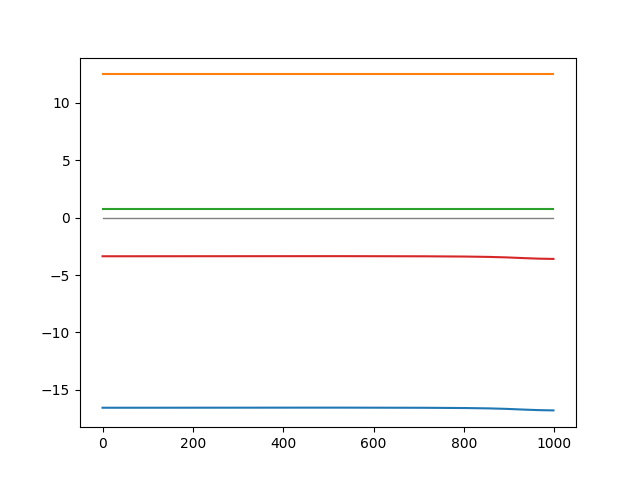

<IPython.core.display.Javascript object>


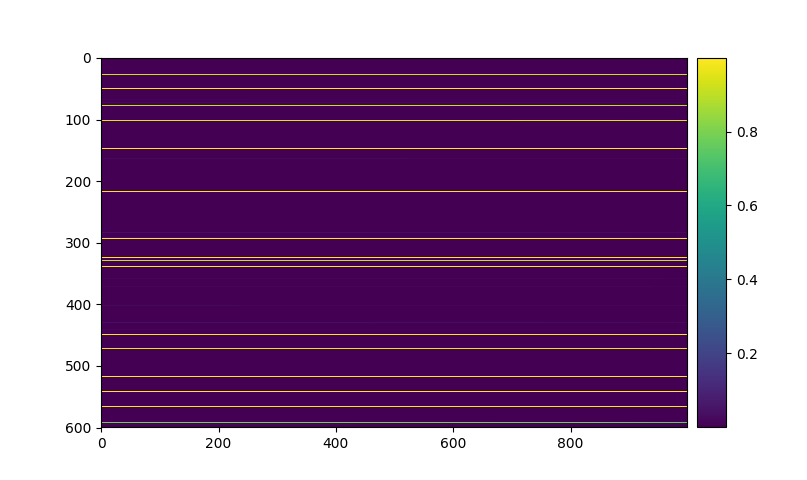

<IPython.core.display.Javascript object>


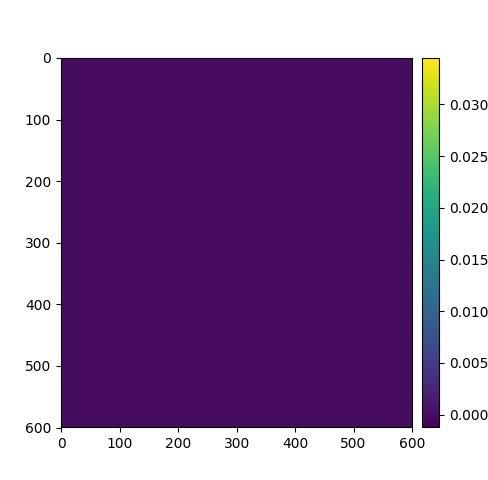

<IPython.core.display.Javascript object>


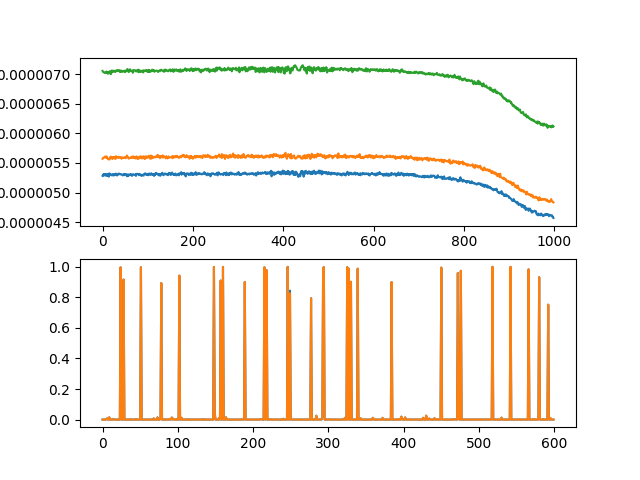

-16.5766 12.0309 6.97791
Sparsity: 0.046053


In [1578]:
start, stop = -1000, -1

R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]

H_FVxHD_INH = accumulate_activation(outdir, 'FVxHD', ['FVxHD'], N_FVxHD, slice(start, stop), INH=True) # 'HD'
H_FV_FVxHD = accumulate_activation(outdir, 'FVxHD', ['FV'], N_FVxHD, slice(start, stop))
H_HD_FVxHD = accumulate_activation(outdir, 'FVxHD', ['HD'], N_FVxHD, slice(start, stop))
H_FVxHD = H_FVxHD_INH + H_HD_FVxHD + H_FV_FVxHD
imshow(H_FVxHD) #[W_idx_s])

# blue, orange, green, red, purple
fig, ax = plt.subplots()
j = 199
ax.plot(R_FV[0]*np.min(H_FVxHD_INH[j]), color='gray', lw=1)
ax.plot(H_FVxHD_INH[j])
ax.plot(H_FV_FVxHD[j])
ax.plot(H_HD_FVxHD[j])
ax.plot(H_FVxHD[j])

R_FVxHD = np.array(read_rates(outdir, 'FVxHD', N_FVxHD)[:, start:stop])
imshow(R_FVxHD) # [W_idx_s])
imshow(np.cov(R_FVxHD))
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_FVxHD[10])
ax[0].plot(R_FVxHD[250])
ax[0].plot(R_FVxHD[500])
ax[1].plot(R_FVxHD[:, -1])
ax[1].plot(R_FVxHD[:, -17])

print(np.mean(H_FVxHD_INH), np.mean(H_FV_FVxHD), np.mean(H_HD_FVxHD))
print('Sparsity: %f' % (np.mean(np.sum(R_FVxHD, 0)) / N_FVxHD))

<IPython.core.display.Javascript object>


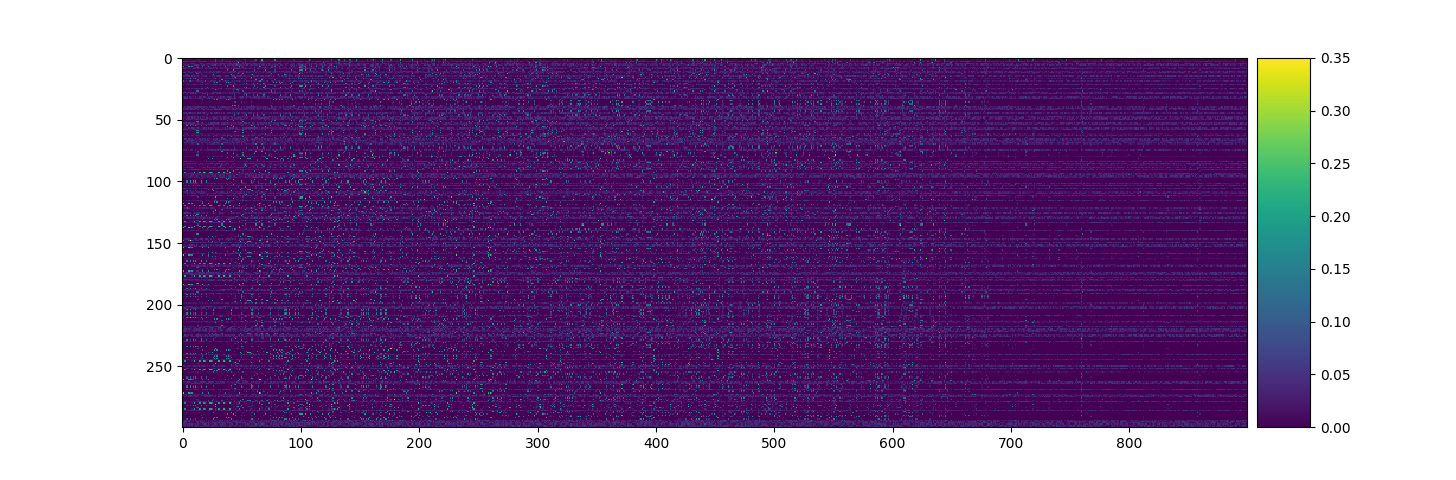

<IPython.core.display.Javascript object>


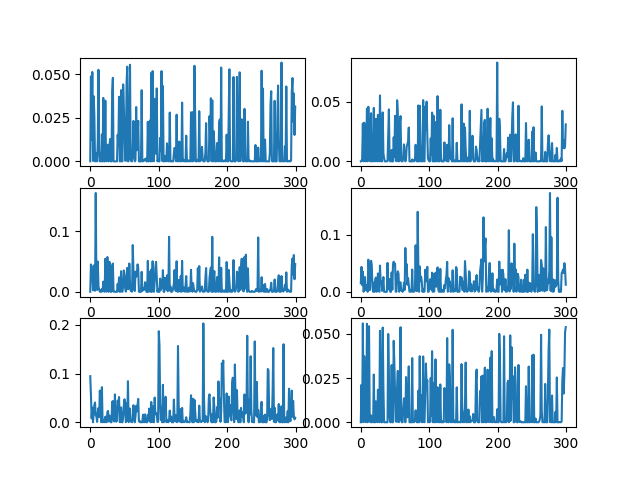

<IPython.core.display.Javascript object>


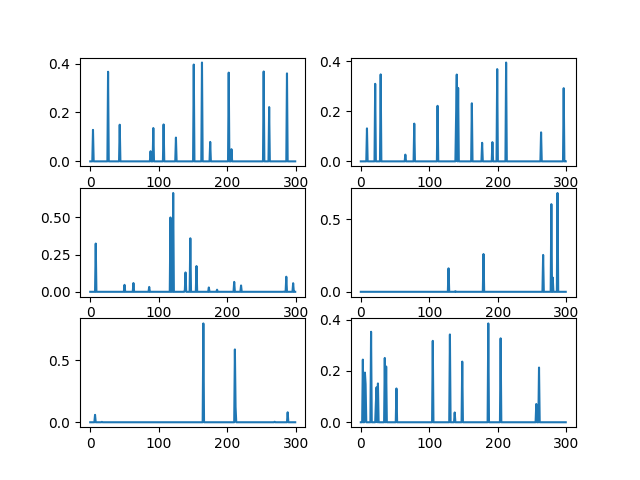

0.326892 0.999994
0.860836 0.99999


In [238]:
W_AHVxHD_HD = read_weights(outdir, 'HD', 'AHVxHD', N_AHVxHD, N_HD)[-1]
W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[-1] # - read_weights(outdir, 'AHVxHD', 'HD', 500, 1000)[0]
#W_idx = np.indices((W_AHVxHD_HD[-1].shape[0],))[0] + 1
W_idx_s = np.argsort(W_HD_AHVxHD @ HD_tuning) # np.sum(W_AHVxHD_HD[-1].T * W_idx, 1))[::-1]
W_idx_t = np.argsort(W_AHVxHD_HD @ W_HD_AHVxHD @ HD_tuning)

imshow(W_AHVxHD_HD[W_VIS_HD_idx][:, W_idx_s])# - W_AHVxHD_HD[0][:, W_idx_s])

fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_AHVxHD_HD[W_VIS_HD_idx, -10]) # .T[W_idx_s[10]]) # -W_AHVxHD_HD[0].T[W_idx_s[10]])
ax[1].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-50]]) # .T[W_idx_s[50]]) # -W_AHVxHD_HD[0].T[W_idx_s[50]])
ax[2].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-300]]) # .T[W_idx_s[300]]) # -W_AHVxHD_HD[0].T[W_idx_s[300]])
ax[3].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-600]]) # .T[W_idx_s[600]]) # -W_AHVxHD_HD[0].T[W_idx_s[600]])
ax[4].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[50]]) # .T[W_idx_s[-50]]) # -W_AHVxHD_HD[0].T[W_idx_s[-50]])
ax[5].plot(W_AHVxHD_HD[W_VIS_HD_idx, 10]) # .T[W_idx_s[-10]]) # -W_AHVxHD_HD[0].T[W_idx_s[-10]])

fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_HD_AHVxHD[-10, W_VIS_HD_idx])
ax[1].plot(W_HD_AHVxHD[W_idx_s[-50], W_VIS_HD_idx])
ax[2].plot(W_HD_AHVxHD[W_idx_s[-300], W_VIS_HD_idx])
ax[3].plot(W_HD_AHVxHD[W_idx_s[-600], W_VIS_HD_idx])
ax[4].plot(W_HD_AHVxHD[W_idx_s[50], W_VIS_HD_idx])
ax[5].plot(W_HD_AHVxHD[10, W_VIS_HD_idx])

print(np.linalg.norm(W_AHVxHD_HD[:, -10]),
      np.linalg.norm(W_HD_AHVxHD[-10, :]))
print(np.linalg.norm(W_AHVxHD_HD[:, W_idx_s[1]]),
      np.linalg.norm(W_HD_AHVxHD[W_idx_s[1], :]))

#imshow(W_HD_AHVxHD)

<IPython.core.display.Javascript object>


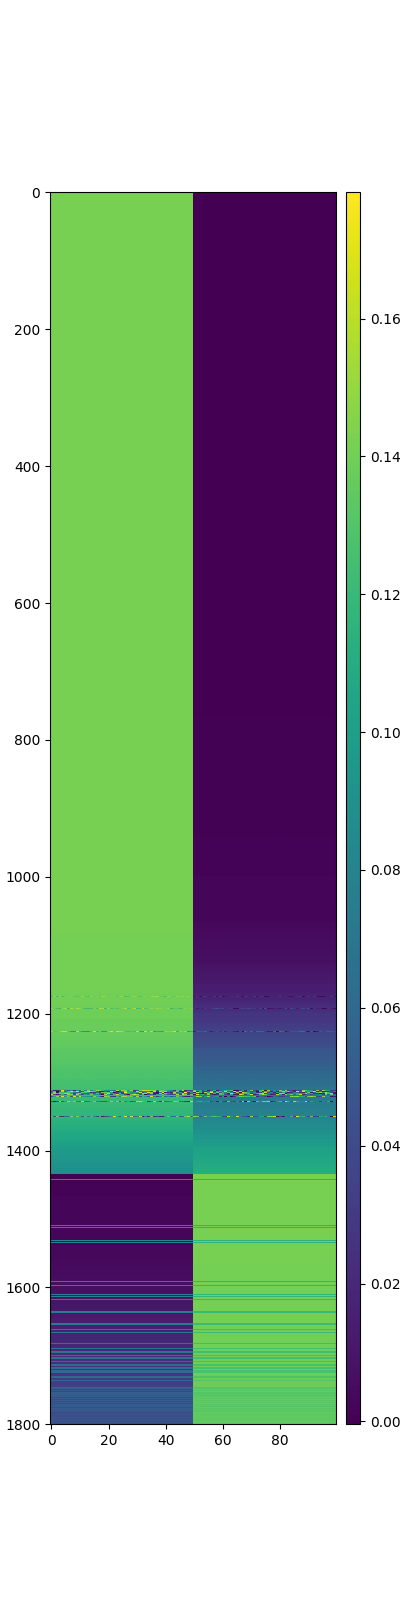

1.0
0.749615 0.250385 0.0


In [76]:
W_FV_GRIDxFVxHD = read_weights(outdir, 'GRIDxFVxHD', 'FV', N_FV, N_GRIDxFVxHD)[-1]
W_FV_GRIDxFVxHD_cum = np.c_[np.sum(W_FV_GRIDxFVxHD[:,:50], 1),
                             np.sum(W_FV_GRIDxFVxHD[:,50:100], 1),
                         np.sum(W_FV_GRIDxFVxHD[:,100:], 1)]
imshow(W_FV_GRIDxFVxHD[np.argsort(W_FV_GRIDxFVxHD_cum@np.array([25,75,125]))])
print(np.linalg.norm(W_FV_GRIDxFVxHD[10]))
print(np.sum(W_FV_GRIDxFVxHD[:,:50])/np.sum(W_FV_GRIDxFVxHD),
      np.sum(W_FV_GRIDxFVxHD[:,50:100])/np.sum(W_FV_GRIDxFVxHD),
      np.sum(W_FV_GRIDxFVxHD[:,100:])/np.sum(W_FV_GRIDxFVxHD))

In [1201]:
W_VIS_HD = read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[-1]
#W_VIS_HD[W_VIS_HD_idx] += np.fliplr(np.identity(N_HD) * 0.5)
W_VIS_HD.tofile('VIS/W_VIS_HD.bin')

W_AHVxHD_HD = read_weights(outdir, 'HD', 'AHVxHD', N_AHVxHD, N_HD)[-1]
#W_AHVxHD_HD = np.random.random(W_AHVxHD_HD.shape).astype(np.float32)
#W_AHVxHD_HD = scipy.sparse.rand(W_AHVxHD_HD.shape[0], W_AHVxHD_HD.shape[1], 0.4, dtype=np.float32).todense()
##N_REGRID = 80
##W_tmp = W_AHVxHD_HD.copy()
##W_tmp[:, W_idx_s[-N_REGRID:]] = (1+np.random.random((500, N_REGRID)))/100
##W_tmp.tofile('W_AHVxHD_HD.bin')
W_AHVxHD_HD.tofile('VIS/W_AHVxHD_HD.bin')

W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[-1]
#W_HD_AHVxHD = scipy.sparse.rand(W_HD_AHVxHD.shape[0], W_HD_AHVxHD.shape[1], 0.05, dtype=np.float32).todense()
##W_tmp = W_HD_AHVxHD.copy()
##W_tmp__ = W_HD_AHVxHD.copy()
##W_tmp[W_idx_s[-N_REGRID:], :][W_tmp[W_idx_s[-N_REGRID:], :] > 0] = 0.1
W_HD_AHVxHD.tofile('VIS/W_HD_AHVxHD.bin')

W_AHV_AHVxHD = read_weights(outdir, 'AHVxHD', 'AHV', N_AHV, N_AHVxHD)[-1]
W_AHV_AHVxHD.tofile('VIS/W_AHV_AHVxHD.bin')

#imshow(W_HD_AHVxHD)

In [1745]:
plt.close('all')

<IPython.core.display.Javascript object>


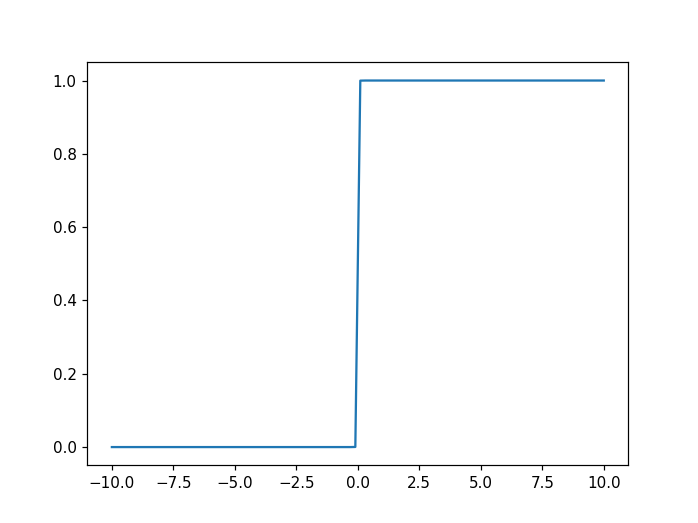

In [1495]:
fig, ax = plt.subplots()
X = np.linspace(-10, 10, 100)
ax.plot(X, 0.5*(np.tanh(40*X)+1))